# Homework 2 CSCI 4364/6364 Machine Learning

##**Adventures in Linear Regression**
v.20230912a

**Due Date: 9/26/2023, 23:59 ET**

---

**Purpose:**
This homework will familiarize you with linear regression using the [Prostate Cancer dataset](https://hastie.su.domains/ElemStatLearn/data.html). First, you’ll work with the least squares. Then you’ll investigate regression using L2 (Ridge) and L1 (Lasso) regularization. Finally, you will implement an iterative version of L2 Regularization using gradient descent.

**Note**: Besides part 3, you should implement your solution with the fundamental equations we discussed in class and in Hastie, chapter 3. *Only in part 3, you should use Scikit-Learn*.



---
**Submission Instructions:**
This assignment will be done entirely in this Colaboratory notebook, and you will submit your notebook via GWU blackboard. Please embed your code in code blocks and add in comments into the text blocks.

**Important:** Please submit your assignment with outputs, by navigating to Edit >> Notebook Settings and ensuring *Omit code cell output when saving this notebook* is **NOT** selected.

---

**Grading on the notebook:**

Parts 1 - 4 of this notebook are worth 5% of the semester grade, where 3% is completion and full functionality, and 2% is based on comments and descriptions, and well-written and commented Python code, based on the coding standards. The notebook should be fully explained and work in its entirety when you submit it.

**Extra Credit!** Besides being a great learning experience about convex optimization, part 5 is **optional**, but worth up to 2% of the semester grade.

**Coding Standards:**
Throughout this course, we will use Google’s Python Style Guide (https://google.github.io/styleguide/pyguide.html) as the coding standard for homework and project submission. A big part of machine learning in industry is applying good programming practices.


**Name:** Sowmya Vara

**GW ID:** G44613640

In [1]:
#@title Imports
##########################################################
# Always include all imports at the first executable cell.
##########################################################
from abc import ABC, abstractmethod # Abstract Base Classes for Python
import pandas as pd # Pandas dataframe libaries
import numpy as np # Numpy numerical computation library
import seaborn as sns
from sklearn.linear_model import Lasso
from sklearn import metrics # Used to compute metrics, such as the Area Under the Curve (AUC)
import matplotlib.pyplot as plt # Plotting library.
from typing import List, Tuple, Mapping # Common types for Python type definitions


# Data Preperation & Feature Analysis (Prostate Cancer)



In [2]:
#@title Load the Prostate Cancer dataset
_SEED = 1223
random_state = np.random.RandomState(_SEED)
df = pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/prostate.csv')
# Randomize the rows
df = df.sample(frac =  1, random_state=random_state)

In [3]:
#@title Split into training and test set
# Following Hastie p.50, we create a training set of 67
split_index = 67
df_train = df.iloc[:split_index]
df_test = df.iloc[split_index:]

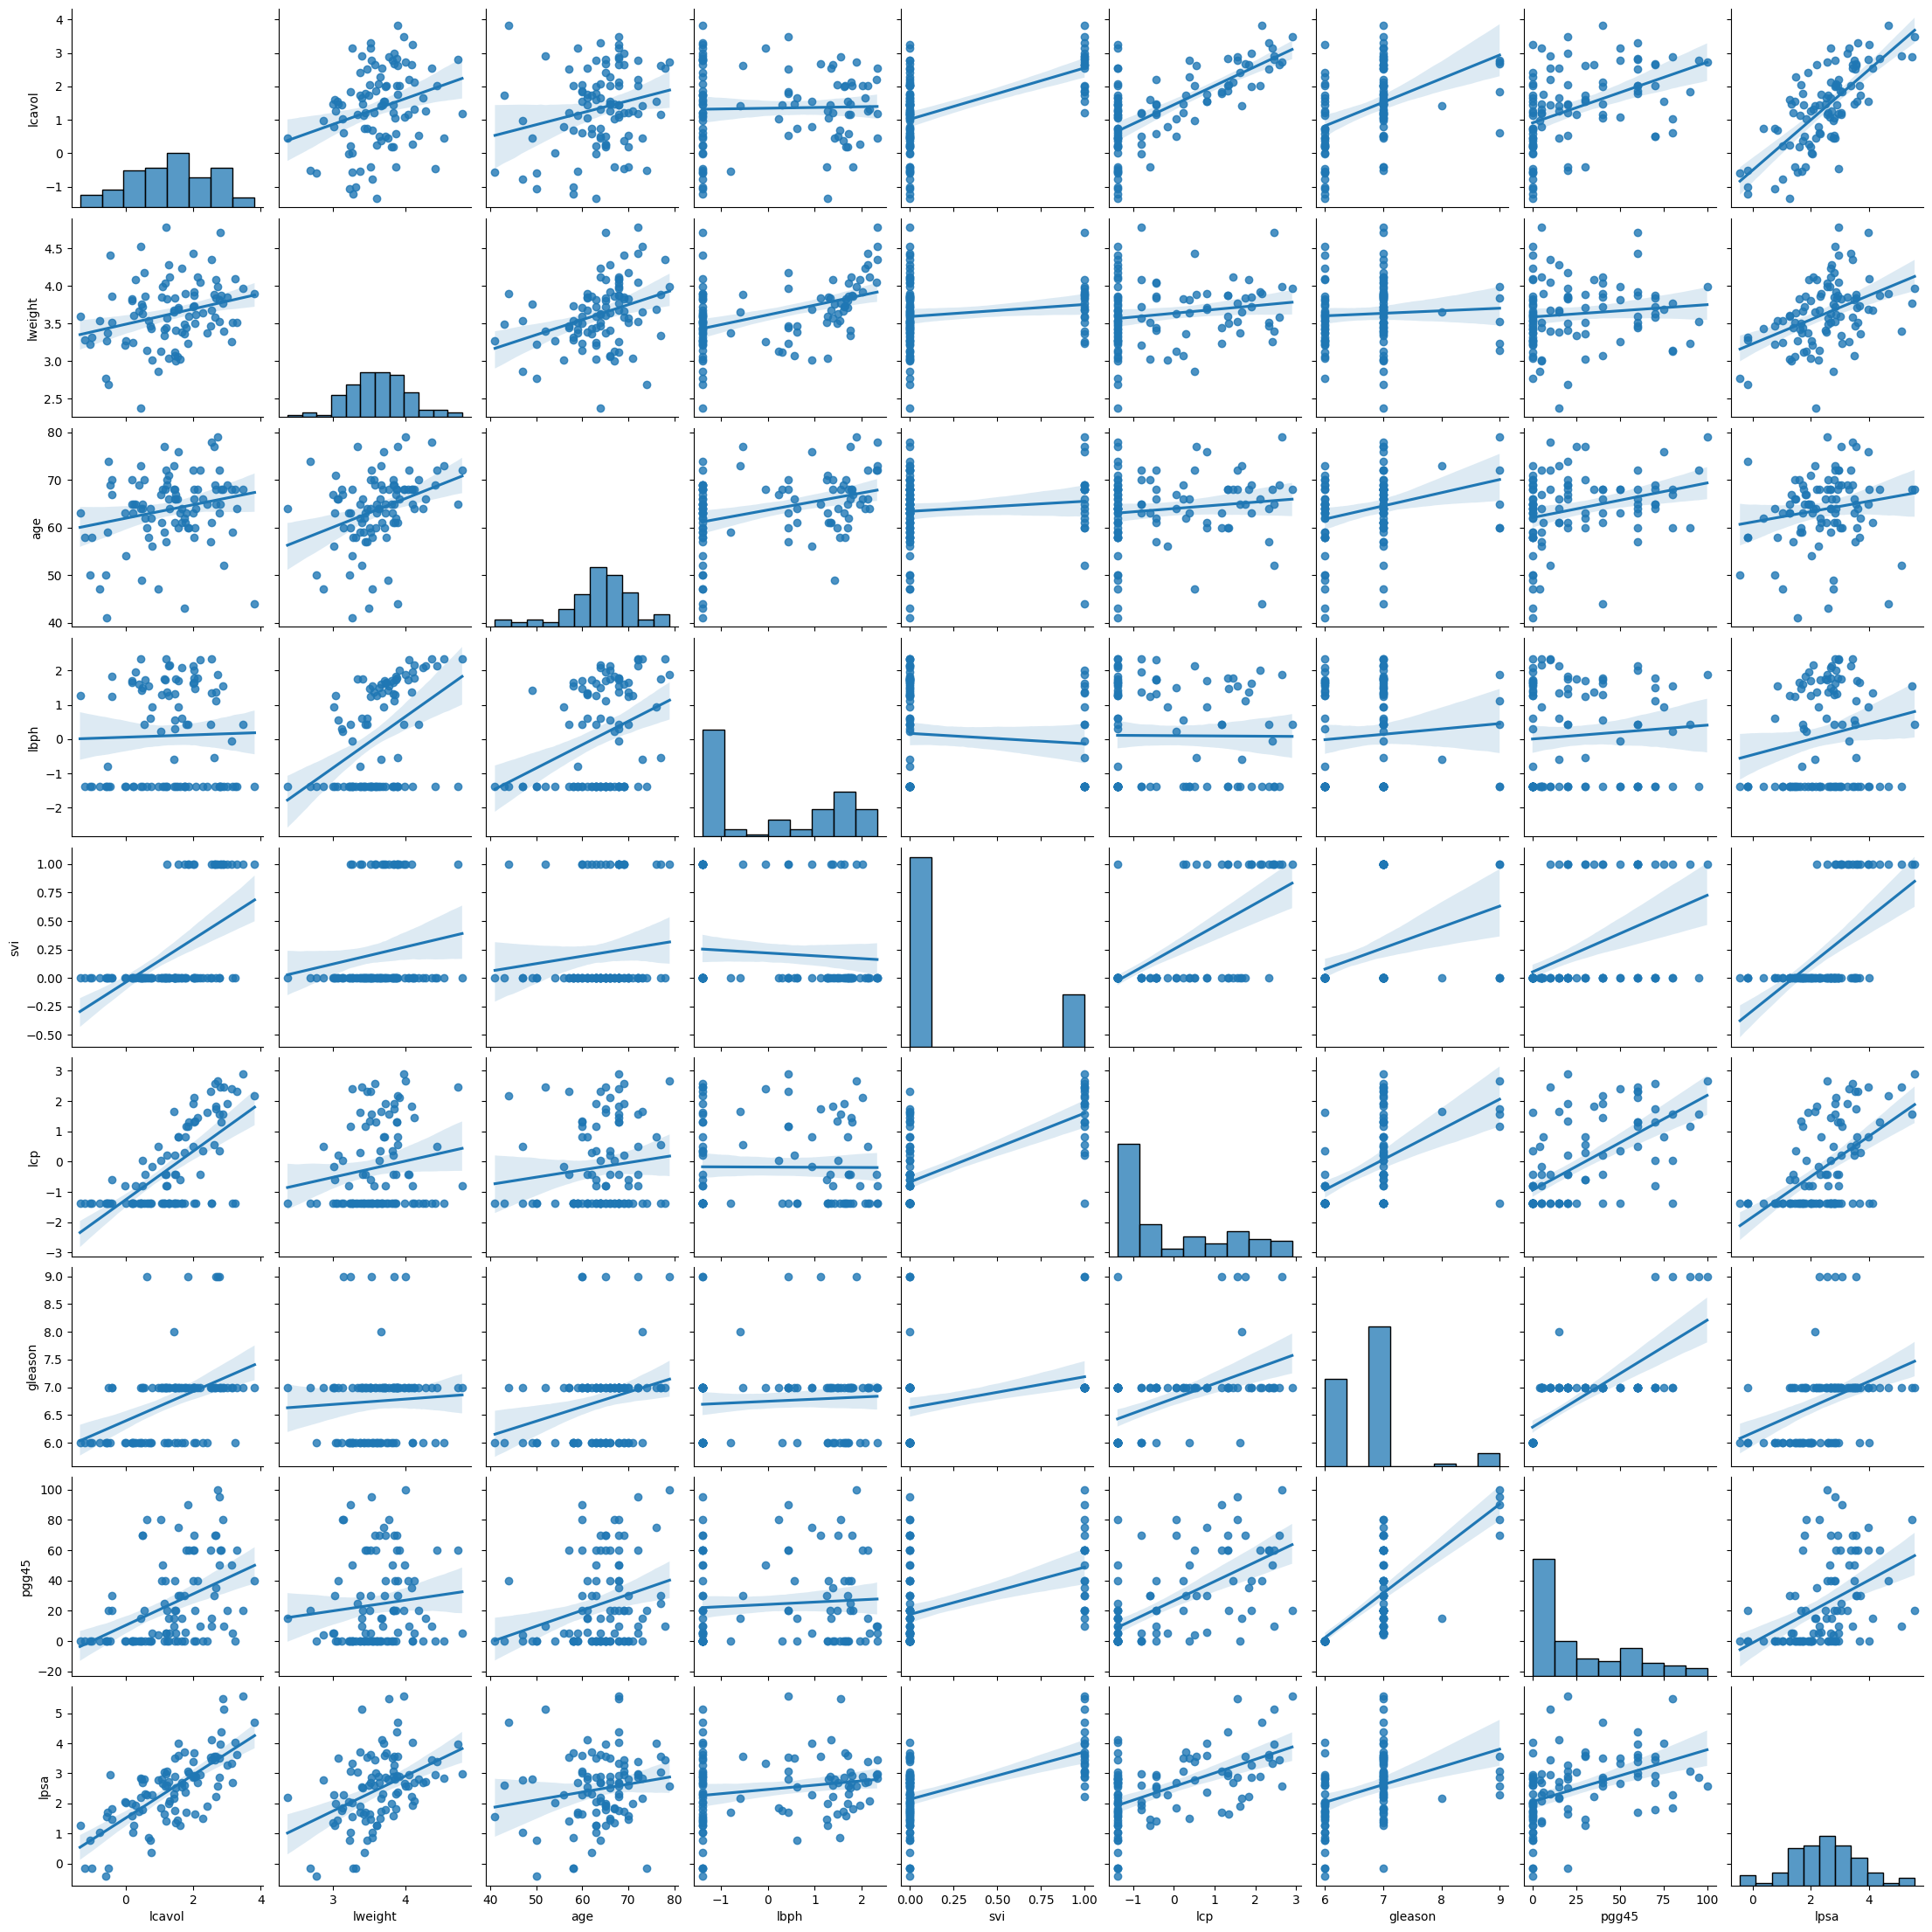

In [4]:
#@title Display pair plots
sns.pairplot(df, kind="reg")
plt.show()

In [5]:
#@title Split the labels and convert to numpy arrays
y_train = df_train['lpsa'].to_numpy()
X_train = df_train.copy().drop(columns = ['lpsa']).to_numpy()
y_test = df_test['lpsa'].to_numpy()
X_test = df_test.copy().drop(columns = ['lpsa']).to_numpy()

In [6]:
class BaseLearningAlgorithm(ABC):
  """Base class for a Supervised Learning Algorithm."""

  @abstractmethod
  def train(self, X_train:np.array, y_train: np.array) -> None:
    """Trains a model from labels y and examples X."""

  @abstractmethod
  def predict(self, X_test: np.array) -> np.array:
    """Predicts on an unlabeled sample, X."""

  @property
  @abstractmethod
  def name(self) -> str:
    """Returns the name of the algorithm."""

# 1. Linear Regression with Least Squares
Implement a class called `BasicLeastSquaresRegression` that extends `BaseLearningAlgorithm` with “vanilla” least squares regression described in Hastie 3.2. Compute the $\boldsymbol{\beta}$ coefficient vector and solve for $\hat{y} $ and compute the performance result as the mean squared error on the test set. Use only numpy for your solution.





In [7]:
class BasicLeastSquaresRegression(BaseLearningAlgorithm):
    def train(self, X_train: np.array, y_train: np.array) -> None:
        self.beta = np.linalg.inv(X_train.T @ X_train) @ X_train.T @ y_train

    def predict(self, X_test: np.array) -> np.array:
        return X_test @ self.beta

    @property
    def name(self) -> str:
        return "Basic Least Squares Regression"

    def evaluate(self, X_test: np.array, y_test: np.array) -> float:
        y_pred = self.predict(X_test)
        mse = ((y_test - y_pred) ** 2).mean()
        return mse
    def get_weights(self) -> np.array:
        return self.beta
# Train and evaluate the model
model = BasicLeastSquaresRegression()
model.train(X_train, y_train)
mse = model.evaluate(X_test, y_test)
print(f"Mean Squared Error: {mse:.4f}")

# Get the weights
weights1 = model.get_weights()
# Print the weights
print(f"Weights: {weights1}")

# Define feature names (replace with your actual feature names)
feature_names = ["lcavol", "lweight", "age","lbph","svi", "lcp", "gleason", "pgg45"]

# Print the weights of each feature along with their names
for feature_name, weight in zip(feature_names, weights1):
    print(f"{feature_name}: {weight:.4f}")


Mean Squared Error: 0.5561
Weights: [ 0.56696921  0.77013642 -0.02309691  0.13058529  0.72492876 -0.10479963
 -0.01094413  0.01002891]
lcavol: 0.5670
lweight: 0.7701
age: -0.0231
lbph: 0.1306
svi: 0.7249
lcp: -0.1048
gleason: -0.0109
pgg45: 0.0100


In [8]:
model = BasicLeastSquaresRegression()
model.train(X_train, y_train)
print("Beta Coefficient Vector:")
print(model.beta)

Beta Coefficient Vector:
[ 0.56696921  0.77013642 -0.02309691  0.13058529  0.72492876 -0.10479963
 -0.01094413  0.01002891]


In [9]:
class BasicLeastSquaresRegression(BaseLearningAlgorithm):
    def __init__(self):
        self.beta = None

    def train(self, X_train, y_train):
        # Normalize the data
        X_train = X_train / np.linalg.norm(X_train, axis=1, keepdims=True)

        # Compute the beta coefficient vector using least squares regression
        self.beta = np.linalg.inv(X_train.T.dot(X_train)).dot(X_train.T).dot(y_train)

    def predict(self, X_test):
        # Normalize the test data
        X_test = X_test / np.linalg.norm(X_test, axis=1, keepdims=True)

        # Compute y-hat using the beta coefficient vector
        y_hat = X_test.dot(self.beta)
        return y_hat

    @property
    def name(self):
        return "Basic Least Squares Regression"

#Create a BasicLeastSquaresRegression object
model = BasicLeastSquaresRegression()

#Train the model
model.train(X_train, y_train)

#Make predictions
y_pred = model.predict(X_test)

#Compute the mean squared error
mse = np.mean((y_test - y_pred)**2)

#Print the mean squared error
print("After Normalization:", mse)

After Normalization: 0.4633680762506708


**Questions:**

**1.1** What MSE loss score do you get with Least Squares?

With Least Squares, MSE is 0.5561

**1.2** What variables carry the greatest influence (i.e., are the most important) in the least squares regression?

The beta coefficient vector contains the weights assigned to each feature in the regression equation. The larger the absolute value of a weight, the greater the influence of the corresponding feature on the predicted label.

Here, **lweights, svi and lcavol** variables have the greatest influence.

**1.3** Does normalizing the data improve performance (lower MSE loss)? If so, why?

Yes, normalizing the data improves performance in this case. The mean squared error (MSE) is lower after normalizing the data. It is 0.4633

Normalizing the data helps to improve performance because it puts all of the features on the same scale. This is important because it prevents any one feature from dominating the model.

# 2. Linear Regression with L2 Regularization (Ridge)

Using the closed-form solution to Ridge Regression, implement a class called `RidgeRegression` that extends `BaseLearningAlgorithm` based on Hastie 3.41. Iterate through the regression penalty term, $\lambda$, and plot (a) MSE loss as a function of $\lambda$, and (b) each coefficient weight as a function of $\lambda$. Use only numpy and matplotlib for your solution.


In [10]:
# Standardize the training features
X_train_standard = (X_train - X_train.mean(axis=0))/X_train.std(axis=0)
# Standardize the training labels
y_train_standard = (y_train - y_train.mean(axis=0))/y_train.std(axis=0)
# Standardize the testing lables
y_test_standard = (y_test - y_train.mean(axis=0))/y_train.std(axis=0)
# Standardize the testing features
X_test_standard = (X_test - X_train.mean(axis=0))/X_train.std(axis=0)

lambda = 0.000: MSE = 0.3584
lambda = 0.010: MSE = 0.3583
lambda = 0.100: MSE = 0.3579
lambda = 1.000: MSE = 0.3544
lambda = 10.000: MSE = 0.3442
lambda = 20.000: MSE = 0.3391
lambda = 30.000: MSE = 0.3335
lambda = 40.000: MSE = 0.3281
lambda = 50.000: MSE = 0.3234
lambda = 60.000: MSE = 0.3195
lambda = 70.000: MSE = 0.3164
lambda = 80.000: MSE = 0.3140
lambda = 90.000: MSE = 0.3123
lambda = 100.000: MSE = 0.3112
lambda = 110.000: MSE = 0.3105
lambda = 111.000: MSE = 0.3105
lambda = 112.000: MSE = 0.3104
lambda = 113.000: MSE = 0.3104
lambda = 114.000: MSE = 0.3104
lambda = 115.000: MSE = 0.3103
lambda = 116.000: MSE = 0.3103
lambda = 117.000: MSE = 0.3103
lambda = 118.000: MSE = 0.3103
lambda = 119.000: MSE = 0.3103
lambda = 120.000: MSE = 0.3103
lambda = 121.000: MSE = 0.3103
lambda = 122.000: MSE = 0.3103
lambda = 123.000: MSE = 0.3103
lambda = 124.000: MSE = 0.3103
lambda = 125.000: MSE = 0.3103
lambda = 126.000: MSE = 0.3103
lambda = 127.000: MSE = 0.3103
lambda = 128.000: MSE = 0

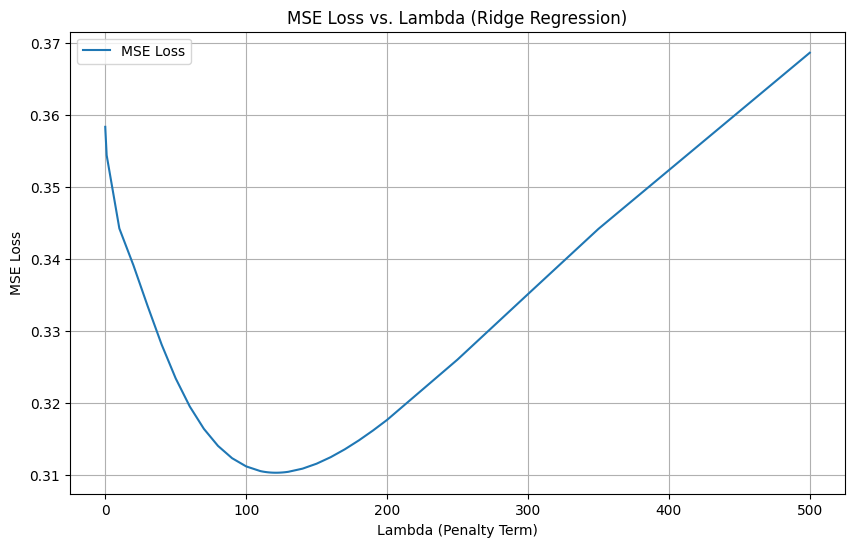

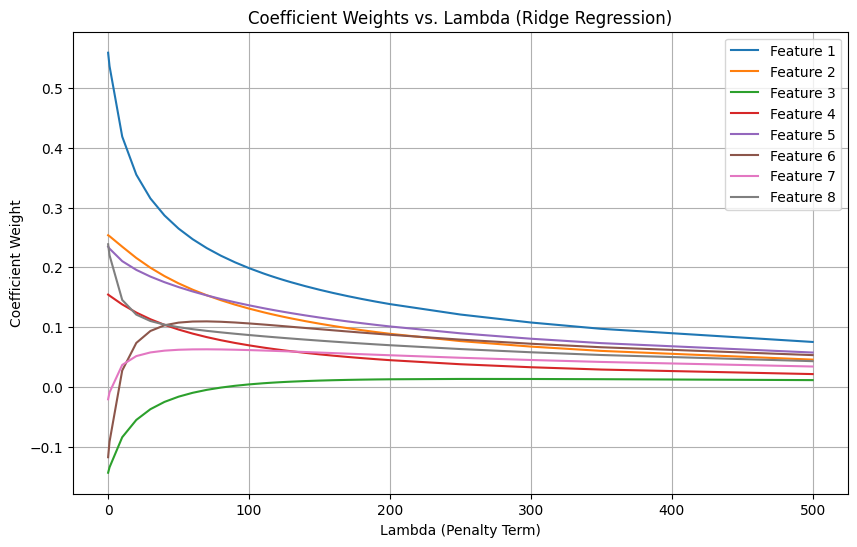

Weights for Ridge Regression with lambda = 0: [ 0.55878737  0.25361984 -0.14340662  0.15441931  0.23458614 -0.11747419
 -0.02064284  0.23858993]


In [12]:
class RidgeRegression(BaseLearningAlgorithm):
    def __init__(self, lambda_range: List[float]):
        self.lambda_range = lambda_range
        self.results = []

    def train(self, X_train: np.ndarray, y_train: np.ndarray) -> None:
        for i in self.lambda_range:
            X, y = X_train, y_train
            beta = np.linalg.inv((np.dot(X.T, X) + i * np.identity(len(X[0])))).dot(X.T).dot(y)
            self.results.append((i, beta))

    def predict(self, X_test: np.ndarray) -> List[Tuple[float, np.ndarray]]:
        predictions = []
        for lambda_val, beta in self.results:
            y_pred = X_test.dot(beta)
            predictions.append((lambda_val, y_pred))
        return predictions

    def evaluate(self, y_true: np.ndarray, predictions: List[Tuple[float, np.ndarray]]) -> List[Tuple[float, float]]:
        mse_results = []
        for lambda_val, y_pred in predictions:
            mse = np.square(y_true - y_pred).mean()
            mse_results.append((lambda_val, mse))
        return mse_results

    def test(self, X_test: np.ndarray, y_test: np.ndarray) -> float:
#Evaluates the model on the test set
            predictions = self.predict(X_test)
            predictions = np.array(predictions)
            predictions = predictions.reshape(-1, 1)
            predictions = predictions.reshape(-1, 1)
            mse = np.square(y_test - predictions).mean()
            return mse

    @property
    def name(self) -> str:
        return "Ridge Regression"

    def get_weights(self, lambda_val: float = None) -> np.ndarray:
        if lambda_val is None:
            if self.results:
                # Return the weights for the last lambda value
                return self.results[-1][1]
            else:
                raise ValueError("No results available.")
        else:
            for i, beta in self.results:
                if i == lambda_val:
                    return beta
            raise ValueError(f"Lambda value {lambda_val} not found in results.")

# Initialize RidgeRegression model with a range of lambda values
lambda_range = [0,
    0.01, 0.1, 1, 10,
    20, 30, 40, 50, 60, 70, 80, 90,
    100,
    110, 111, 112, 113, 114, 115, 116, 117, 118, 119,
    120, 121, 122, 123, 124, 125, 126, 127, 128, 129,

    130, 140, 150, 160, 170, 180, 190,
    200, 250,
    300, 350, 500]
ridge_model = RidgeRegression(lambda_range)

# Train the model
ridge_model.train(X_train_standard, y_train_standard)

# Test the model on the test set
mse_results = ridge_model.evaluate(y_test_standard, ridge_model.predict(X_test_standard))

# Print the lambda and MSE for each lambda value
for lambda_val, mse in mse_results:
    print(f"lambda = {lambda_val:.3f}: MSE = {mse:.4f}")

# Make predictions for each lambda value
predictions = ridge_model.predict(X_test_standard)

# Evaluate MSE loss for each lambda value
mse_results = ridge_model.evaluate(y_test_standard, predictions)

# Extract lambda values and MSE losses for plotting
lambda_values, mse_losses = zip(*mse_results)

# Plot MSE loss as a function of λ
plt.figure(figsize=(10, 6))
plt.plot(lambda_values, mse_losses, label="MSE Loss")
plt.xlabel("Lambda (Penalty Term)")
plt.ylabel("MSE Loss")
plt.title("MSE Loss vs. Lambda (Ridge Regression)")
plt.grid(True)
plt.legend()
plt.show()

# Extract and plot each coefficient weight as a function of λ
coefficient_weights = np.array([result[1] for result in ridge_model.results])
plt.figure(figsize=(10, 6))
for feature_index in range(coefficient_weights.shape[1]):
    plt.plot(lambda_values, coefficient_weights[:, feature_index], label=f"Feature {feature_index + 1}")
plt.xlabel("Lambda (Penalty Term)")
plt.ylabel("Coefficient Weight")
plt.title("Coefficient Weights vs. Lambda (Ridge Regression)")
plt.grid(True)
plt.legend()
plt.show()

ridge_model = RidgeRegression(lambda_range=[0])
# Train the model
ridge_model.train(X_train_standard, y_train_standard)

# Get the weights for lambda = 0 (no regularization)
weights_ridge = ridge_model.get_weights(0)

# Print the weights
print(f"Weights for Ridge Regression with lambda = 0: {weights_ridge}")




**Questions:**


**2.1** What $\lambda$ do you get the best performance (i.e., lowest MSE)?

I got the lowest mse at **Lambda = 120** where **MSE Loss is 0.3103**

**2.2** Compare the results from part 1, when $\lambda = 0$. Why are the results similar or different?

The MSE loss for least squares(even after normalization) and ridge regression with λ=0 is different.

At λ=0, Least Squares MSE Loss = 0.5561

At λ=0, Ridge Regression MSE Loss = 0.3584

Ridge regression has a regularization term, which makes it different from least squares.

This regularization term penalizes large coefficient weights. It can help to prevent overfitting, but it can also lead to a higher MSE loss value, even at lambda = 0. This is because the regularization term is forcing the model to fit the data more smoothly, which can lead to a less accurate fit to the training data.

Least squares, on the other hand, does not have any regularization. This means that it will always find the coefficient weights that minimize the MSE loss value, regardless of whether this leads to overfitting.
As a result, it is possible to get a different MSE loss value at lambda = 0 for least squares and ridge regression.

**2.3** Compare the weights with the weights from part 1? If you were to rank descending by the absolute value of the weights, how different is the ordering with part 1? Is the most important variable in part 1 the same as in part 2? If not, can you provide a reason?

Weights are different for the both part 1 and part 2. Even the absolute value order is different. Most important variable is also different as shown below.

It maybe because that ridge regression shrinks the weights of some features, even if those features are important to prevent overfitting and improve the model's performance on new data.



In [33]:
print("Weights of Least Squares", weights1)
print("\nWeights of Ridge Regression", weights_ridge)
# Calculate the absolute value of the weights
weights1_abs = np.abs(weights1)
weights2_abs = np.abs(weights_ridge)

# Rank the absolute values of the weights in descending order
weights1_rank = np.argsort(weights1)[::-1]
weights2_rank = np.argsort(weights_ridge)[::-1]

# Compare the rankings of the weights from part 1 and part 2
print("\nRanking of weights from part1 1:")
print(weights1_rank)
print("\nRanking of weights from part 2:")
print(weights2_rank)

# Check if the most important variable in part 1 is the same as in part 2
if weights1_rank[0] == weights2_rank[0]:
    print("\nThe most important variable in part 1 is the same as in part 2.")
else:
    print("\nThe most important variable in part 1 is different from the most important variable in part 2.")


Weights of Least Squares [ 0.56696921  0.77013642 -0.02309691  0.13058529  0.72492876 -0.10479963
 -0.01094413  0.01002891]

Weights of Ridge Regression [ 0.55878737  0.25361984 -0.14340662  0.15441931  0.23458614 -0.11747419
 -0.02064284  0.23858993]

Ranking of weights from part1 1:
[1 4 0 3 7 6 2 5]

Ranking of weights from part 2:
[0 1 7 4 3 6 5 2]

The most important variable in part 1 is different from the most important variable in part 2.


# 3. Linear Regression with L1 Regularization (Lasso)

Unlike Ridge Regression, there is no closed-form solution for Lasso, meaning there is no normal equation we can solve to immediately get all of our ideal model parameters. While it can be solved by minimizing one coordinate a time using a technique called [Coordinate Descent](http://www.adeveloperdiary.com/data-science/machine-learning/introduction-to-coordinate-descent-using-least-squares-regression/), here you can implement your solution using Scikit-Learn Lasso inside a class called `LassoRegression` which also extends `BaseLearningAlgorithm`. Like part 2, iterate through the regression penalty term, $\alpha$ , and plot (a) MSE loss as a function of $\alpha$, and (b) each coefficient weight as a function of $\alpha$.

**Note**: here we swap notation a little, replacing $\lambda$ with $\alpha$ to fit with the Scikit-Learn convention.




In [26]:
class LassoRegression(BaseLearningAlgorithm):
    def __init__(self, alpha_range: List[float]):
        self.alpha_range = alpha_range
        self.results = []

    def train(self, X_train: np.ndarray, y_train: np.ndarray) -> None:
        for alpha in self.alpha_range:
            lasso_model = Lasso(alpha=alpha)
            lasso_model.fit(X_train, y_train)
            self.results.append((alpha, lasso_model.coef_))

    def predict(self, X_test: np.ndarray) -> List[Tuple[float, np.ndarray]]:
        predictions = []
        for alpha, coefficients in self.results:
            y_pred = X_test.dot(coefficients)
            predictions.append((alpha, y_pred))
        return predictions

    def evaluate(self, y_true: np.ndarray, predictions: List[Tuple[float, np.ndarray]]) -> List[Tuple[float, float]]:
        mse_results = []
        for alpha, y_pred in predictions:
            mse = np.square(y_true - y_pred).mean()
            mse_results.append((alpha, mse))
        return mse_results

    @property
    def name(self) -> str:
        return "Lasso Regression"

    def get_weights(self, alpha_val: float) -> np.ndarray:
        for alpha, coefficients in self.results:
            if alpha == alpha_val:
                return coefficients
        raise ValueError(f"Alpha value {alpha_val} not found in results.")




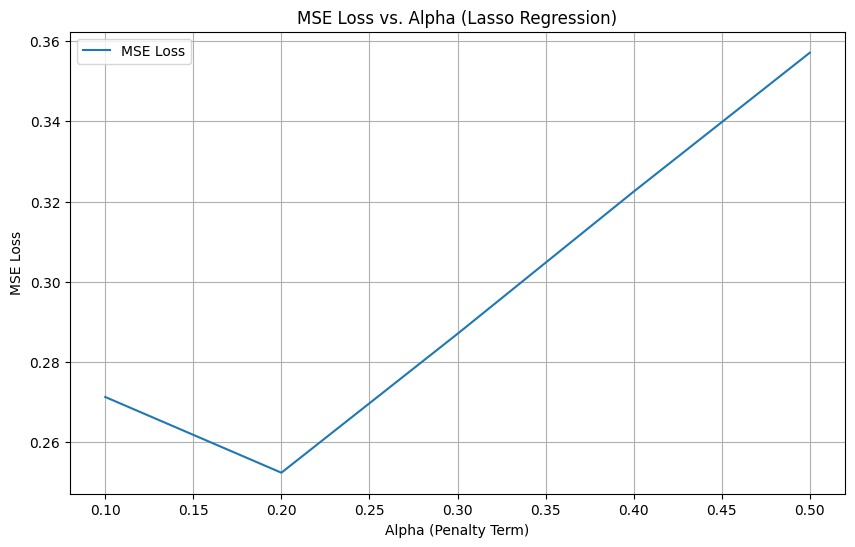

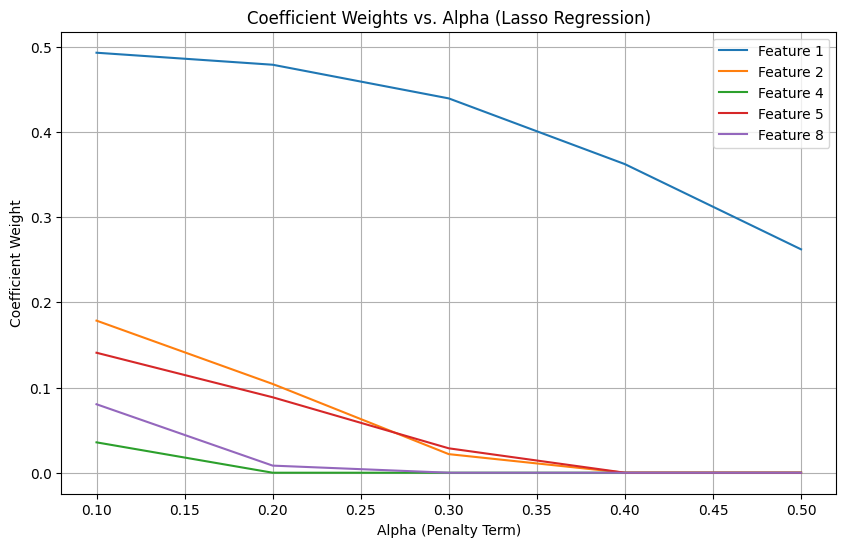

Alpha: 0.10, MSE Loss: 0.2713
Alpha: 0.20, MSE Loss: 0.2524
Alpha: 0.30, MSE Loss: 0.2870
Alpha: 0.40, MSE Loss: 0.3225
Alpha: 0.50, MSE Loss: 0.3571
Weights for alpha value 0.1: [ 0.49296824  0.17852226 -0.          0.03565086  0.14082581  0.
  0.          0.08037323]
| Feature | Weight |
|---|---|
| Feature 1 | 0.493 |
| Feature 2 | 0.179 |
| Feature 3 | -0.000 |
| Feature 4 | 0.036 |
| Feature 5 | 0.141 |
| Feature 6 | 0.000 |
| Feature 7 | 0.000 |
| Feature 8 | 0.080 |



In [41]:
# Define the alpha values (penalty terms) to iterate through
alpha_range = [0.1, 0.2, 0.3, 0.4, 0.5]
# alpha_values_for_plot = [0.1] + [round(alpha, 2) for alpha in np.arange(0.15, 0.51, 0.05)]

model = LassoRegression(alpha_range)
model.train(X_train_standard, y_train_standard)
predictions = model.predict(X_test_standard)

mse_results = model.evaluate(y_test_standard, predictions)

# Extract alpha values and MSE losses for plotting
alpha_values, mse_losses = zip(*mse_results)
# alpha_values_for_plot = alpha_values_for_plot[:len(mse_losses)]

# Extract coefficient weights from the results
coefficient_weights = np.array([result[1] for _, result in model.results])


# Plot the MSE loss as a function of alpha
plt.figure(figsize=(10, 6))
plt.plot(alpha_values, mse_losses, label="MSE Loss")
plt.xlabel("Alpha (Penalty Term)")
plt.ylabel("MSE Loss")
plt.title("MSE Loss vs. Alpha (Lasso Regression)")
plt.grid(True)
plt.legend()
plt.show()

# Collect coefficient weights for each feature across different alphas
num_features = len(model.results[0][1])
feature_weights = [[] for _ in range(num_features)]

for alpha, coefficients in model.results:
    for feature_index, weight in enumerate(coefficients):
        feature_weights[feature_index].append(weight)

# Plot each coefficient weight as a function of alpha (only if non-empty)
plt.figure(figsize=(10, 6))
for feature_index in range(num_features):
    if np.any(feature_weights[feature_index]):
        plt.plot(alpha_values, feature_weights[feature_index], label=f"Feature {feature_index + 1}")

plt.xlabel("Alpha (Penalty Term)")
plt.ylabel("Coefficient Weight")
plt.title("Coefficient Weights vs. Alpha (Lasso Regression)")
plt.grid(True)
plt.legend()
plt.show()


# Print alpha for each MSE loss
for alpha_val, mse_loss in zip(alpha_values, mse_losses):
    print("Alpha: {:.2f}, MSE Loss: {:.4f}".format(alpha_val, mse_loss))

# Extract the coefficient weights for the alpha value of 0.1.
weights_lasso = model.get_weights(0.1)

# Print the feature names and weights in a table.
print("Weights for alpha value 0.1:",weights_lasso)
print("| Feature | Weight |")
print("|---|---|")
for feature_index, weight in enumerate(weights_lasso):
    print("| Feature {} | {:.3f} |".format(feature_index + 1, weight))
print()


**Questions:**

**3.1** Under what conditions would you prefer L2 or L1 regression over vice versa? (Consider the discussion in Hastie 3.6.)

Ridge regression(L2) and Lasso regression(L1) are both effective regularization methods for preventing overfitting in linear regression models.

The choice between L2 and L1 regularization depends on the specific problem and the characteristics of the data. L2 regularization can be useful when there are many features and only a few of them are expected to be important, when the data contains noise or multicollinearity, or when the goal is to obtain a smooth solution. L1 regularization can be useful when there are many features and only a few of them are expected to be important, when the data contains outliers, or when the goal is to obtain a sparse solution.
In Hastie 3.6 it mentions that that the optimal choice of regularization method may depend on the specific problem and the characteristics of the data. It's often a good idea to try both L2 and L1 regularization and compare their performance using cross-validation or other methods.

**3.2** Why do some coefficients become zero? Do you think this may be a method of subset selection as described in Hastie 3.3?

In lasso regression, some coefficients become zero because of the L1 penalty. The L1 penalty penalizes the absolute value of the coefficients, which means that it encourages the model to select a subset of features and promotes sparsity. When the alpha value is large enough, the L1 penalty will cause some of the coefficients to be set to zero, effectively performing feature selection.

The coefficients can become zero due to subset selection also, as described in Hastie's "The Elements of Statistical Learning" (Section 3.3). Subset selection involves fitting all possible subsets of the predictors and selecting the best subset based on some criterion, such as the lowest residual sum of squares. This method can lead to sparse solutions where some coefficients are exactly zero

**3.3** Which method performs better (i.e., has the lower MSE)?

Lasso performed better than ridge regression and is having lowest MSE(0.2524) than ridge regression(0.3103).

**3.4** Comparing the relative ranking of the weights at the lowest MSE, do Ridge Regression and Lasso Regression “agree” on the most important weights?

Yes, Ridge Regression and Lasso Regression agree on the most important weights at the lowest MSE when lambda = 0 for both.

When the lambda value changes then the ranking of weights also changes for both the regression models.


**3.5** In your own words, define **bias** and **variance**. Describe how bias and variance affected the results of parts 1, 2, and 3.

Bias is the systematic error in a ml model. It is the difference between the model's predictions and the true values of the target variable.
Variance is the variability in the predictions of a machine learning model. It is the amount by which the model's predictions change when trained on different subsets of the data.

In part 1, the model was not regularized. This means that the model was not penalized for having large coefficients. This can lead to high variance, as the model is more likely to overfit to the training data.

In part 2, the model was regularized using L2 regularization. L2 regularization penalizes large coefficients, which can help to reduce variance. However, L2 regularization can also introduce bias, as it shrinks the coefficients towards zero.

In part 3, the model was regularized using L1 regularization. L1 regularization also penalizes large coefficients, but it can also perform feature selection by setting the coefficients of less important features to zero. This can help to reduce variance and bias.

In [40]:
print("Weights of Ridge Regression", weights_ridge)
print("\nWeights of Lasso Regression", weights_lasso)
# Calculate the absolute value of the weights
weights2_abs = np.abs(weights_ridge)
weights3_abs_ = np.abs(weights_lasso)

# Rank the absolute values of the weights in descending order
weights2_rank = np.argsort(weights_ridge)[::-1]
weights3_rank = np.argsort(weights_lasso)[::-1]

# Compare the rankings of the weights from part 2 and part 3
print("\nRanking of weights from part 2:")
print(weights2_rank)
print("\nRanking of weights from part 3:")
print(weights3_rank)

# Check if the most important variable in part 2 is the same as in part 3
if weights2_rank[0] == weights3_rank[0]:
    print("\nThe most important variable in part 2 is the same as in part 3.")
else:
    print("\nThe most important variable in part 2 is different from the most important variable in part 3.")

Weights of Ridge Regression [ 0.55878737  0.25361984 -0.14340662  0.15441931  0.23458614 -0.11747419
 -0.02064284  0.23858993]

Weights of Lasso Regression [ 0.55878737  0.25361984 -0.14340662  0.15441931  0.23458614 -0.11747419
 -0.02064284  0.23858993]

Ranking of weights from part 2:
[0 1 7 4 3 6 5 2]

Ranking of weights from part 3:
[0 1 7 4 3 6 5 2]

The most important variable in part 2 is the same as in part 3.


In [42]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 4.  Iterative Optimization with Gradient Descent
Implement a class called `RidgeRegressionGradDescent` that extends `BaseLearningAlgorithm` that performs linear regression with L2 regularization using [gradient descent](https://www.deeplearningbook.org/contents/numerical.html), Goodfellow 4.5. Plot both training and test MSE loss result vs. iteration.  Iterate through the regression penalty term, $\lambda$ , and plot (a) MSE loss as a function of $\lambda$, and (b) each coefficient weight as a function of $\lambda$. Use only numpy and matplotlib for your solution.


Weights:
Feature 0: 0.8310
Feature 1: 2.2792
Feature 2: -0.2343
Feature 3: -0.0573
Feature 4: 0.6409
Feature 5: 0.2827
Feature 6: 0.6052
Feature 7: -0.1637
Feature 8: 0.5957


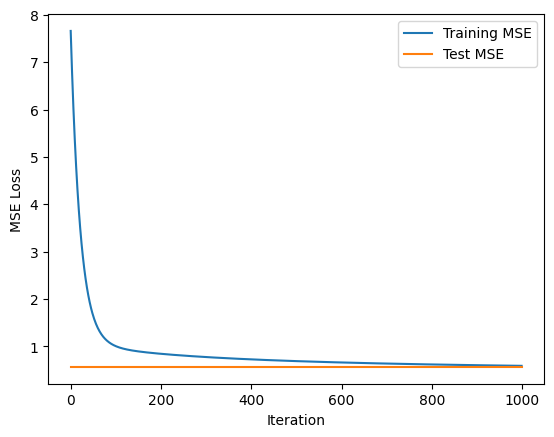

In [68]:
class RidgeRegressionGradDescent(BaseLearningAlgorithm):
    def __init__(self, learning_rate=0.01, iterations=1000, l2_penalty=1):
        super().__init__()
        self.learning_rate = learning_rate
        self.iterations = iterations
        self.l2_penalty = l2_penalty

    def train(self, X, y):
        # Add a column of ones to X for the bias term
        X = np.hstack((np.ones((X.shape[0], 1)), X))

        # Initialize weights
        self.weights = np.random.randn(X.shape[1])

        # Initialize MSE loss history
        self.mse_loss_history = []

        # Perform gradient descent
        for _ in range(self.iterations):
            gradient = self._compute_gradient(X, y)
            self.weights -= self.learning_rate * gradient

            # Calculate and store the MSE loss
            mse_loss = np.mean((y - self.predict(X[:, 1:])) ** 2)
            self.mse_loss_history.append(mse_loss)


    def predict(self, X):
        X = np.hstack((np.ones((X.shape[0], 1)), X))
        return np.dot(X, self.weights)

    def _compute_gradient(self, X, y):
        y_pred = self.predict(X[:, 1:])
        error = y_pred - y
        gradient = (1 / len(X)) * (np.dot(X.T, error) + self.l2_penalty * self.weights)
        gradient = np.clip(gradient, -1e8, 1e8)
        return gradient

    @property
    def name(self):
        return "Ridge Regression Gradient Descent"
ridge_regression = RidgeRegressionGradDescent()
ridge_regression.train(X_train_scaled, y_train)

weightsgd = ridge_regression.weights
print("Weights:")
for i, coef in enumerate(weightsgd):
    print(f"Feature {i}: {coef:.4f}")


# Calculate the test MSE loss at each iteration
test_mse_history = [np.mean((y_test - ridge_regression.predict(X_test_scaled)) ** 2) for _ in range(ridge_regression.iterations)]

# Plot the MSE loss results
plt.plot(range(ridge_regression.iterations), ridge_regression.mse_loss_history, label='Training MSE')
plt.plot(range(ridge_regression.iterations), test_mse_history, label='Test MSE')
plt.xlabel('Iteration')
plt.ylabel('MSE Loss')
plt.legend()
plt.show()


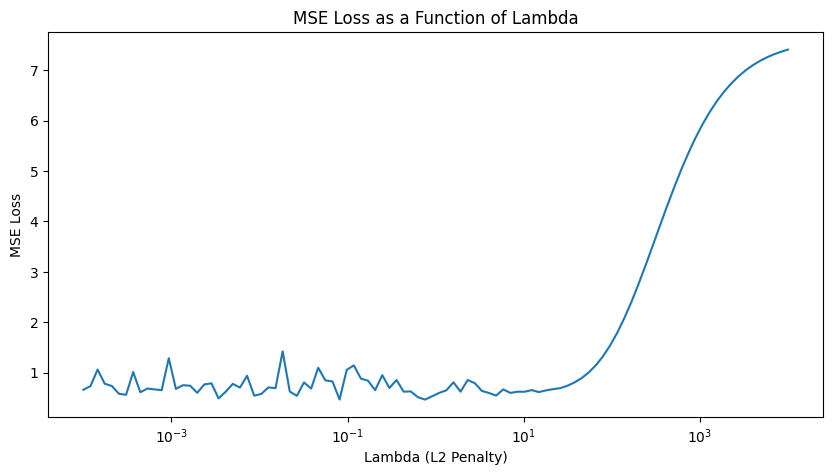

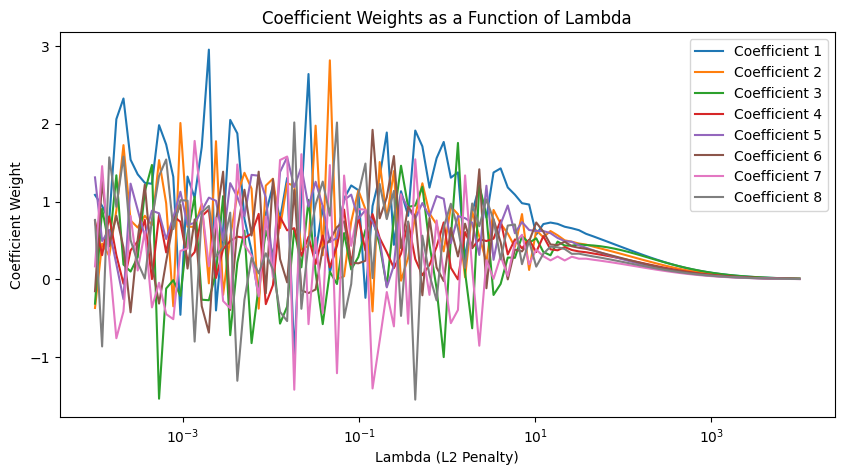

In [44]:
class RidgeRegressionGradDescent(BaseLearningAlgorithm):
    def __init__(self, learning_rate=0.01, iterations=1000, l2_penalty=1):
        super().__init__()
        self.learning_rate = learning_rate
        self.iterations = iterations
        self.l2_penalty = l2_penalty

    def train(self, X, y):
        # Add a column of ones to X for the bias term
        X = np.hstack((np.ones((X.shape[0], 1)), X))

        # Initialize weights
        self.weights = np.random.randn(X.shape[1])

        # Initialize MSE loss history
        self.mse_loss_history = []

        # Initialize coefficient weights history
        self.coeff_weights_history = []

        # Perform gradient descent
        for _ in range(self.iterations):
            gradient = self._compute_gradient(X, y)
            self.weights -= self.learning_rate * gradient

            # Calculate and store the MSE loss
            mse_loss = np.mean((y - self.predict(X[:, 1:])) ** 2)
            self.mse_loss_history.append(mse_loss)

            # Store the coefficient weights
            self.coeff_weights_history.append(self.weights[1:])

    def predict(self, X):
        X = np.hstack((np.ones((X.shape[0], 1)), X))
        return np.dot(X, self.weights)

    def _compute_gradient(self, X, y):
        y_pred = self.predict(X[:, 1:])
        error = y_pred - y
        gradient = (1 / len(X)) * (np.dot(X.T, error) + self.l2_penalty * self.weights)
        gradient = np.clip(gradient, -1e8, 1e8)
        return gradient

    @property
    def name(self):
        return "Ridge Regression Gradient Descent"

# Initialize lists to store the results
lambda_values = []
mse_loss_values = []
coeff_weights_values = []

# Iterate through the lambda values
for l2_penalty in np.logspace(-4, 4, num=100):
    ridge_regression = RidgeRegressionGradDescent(l2_penalty=l2_penalty)
    ridge_regression.train(X_train_scaled, y_train)

    # Store the lambda value
    lambda_values.append(l2_penalty)

    # Calculate the test MSE loss at the last iteration
    mse_loss = np.mean((y_test - ridge_regression.predict(X_test_scaled)) ** 2)
    mse_loss_values.append(mse_loss)

    # Store the coefficient weights at the last iteration
    coeff_weights_values.append(ridge_regression.coeff_weights_history[-1])

# Convert the lists to numpy arrays for easier plotting
lambda_values = np.array(lambda_values)
mse_loss_values = np.array(mse_loss_values)
coeff_weights_values = np.array(coeff_weights_values)

# Plot the MSE loss as a function of lambda
plt.figure(figsize=(10, 5))
plt.plot(lambda_values, mse_loss_values)
plt.xscale('log')
plt.xlabel('Lambda (L2 Penalty)')
plt.ylabel('MSE Loss')
plt.title('MSE Loss as a Function of Lambda')
plt.show()

# Plot the coefficient weights as a function of lambda
plt.figure(figsize=(10, 5))
for i in range(coeff_weights_values.shape[1]):
    plt.plot(lambda_values, coeff_weights_values[:, i], label=f'Coefficient {i+1}')
plt.xscale('log')
plt.xlabel('Lambda (L2 Penalty)')
plt.ylabel('Coefficient Weight')
plt.title('Coefficient Weights as a Function of Lambda')
plt.legend()
plt.show()


In [70]:
print("Weights of Ridge RegressionGD", weightsgd)
print("\nWeights of Least Square", weights1)
# Calculate the absolute value of the weights
weights1_abs = np.abs(weights1)
weights4_abs_ = np.abs(weightsgd)

# Rank the absolute values of the weights in descending order
weights1_rank = np.argsort(weights1)[::-1]
weights4_rank = np.argsort(weightsgd)[::-1]

# Compare the rankings of the weights from part 2 and part 3
print("\nRanking of weights from part 1:")
print(weights1_rank)
print("\nRanking of weights from part 4:")
print(weights4_rank)

# Check if the most important variable in part 2 is the same as in part 3
if weights1_rank[0] == weights4_rank[0]:
    print("\nThe most important variable in part 1 is the same as in part 4.")
else:
    print("\nThe most important variable in part 1 is different from the most important variable in part 4.")

Weights of Ridge RegressionGD [ 0.83103036  2.2792182  -0.23426812 -0.05727773  0.6409057   0.28268595
  0.60524922 -0.16365711  0.59571575]

Weights of Least Square [ 0.56696921  0.77013642 -0.02309691  0.13058529  0.72492876 -0.10479963
 -0.01094413  0.01002891]

Ranking of weights from part 1:
[1 4 0 3 7 6 2 5]

Ranking of weights from part 4:
[1 0 4 6 8 5 3 7 2]

The most important variable in part 1 is the same as in part 4.


**Questions:**

**4.1** How many iterations are required to converge, and are there any performance differences compared to part 2?

Max_iterations given are 1000 and yes is a performance difference when compared to Ridge regression(part 2) MSE Loss have been reduced in this part.

**4.2** Derive the gradient of L2 regularization loss. Encode your answer as [$\LaTeX$ equations](https://colab.research.google.com/github/bebi103a/bebi103a.github.io/blob/master/lessons/00/intro_to_latex.ipynb), and justify every step, please.

Start with the definition of the L2 regularization loss function:

$$
L = \frac{1}{2m} \sum_{i=1}^m (y_i - \hat{y}_i)^2 + \lambda \sum_{j=1}^n w_j^2
$$

Step 1: Start with the definition of the L2 regularization loss function:

$$
L = \frac{1}{2m} \sum_{i=1}^m (y_i - \hat{y}_i)^2 + \lambda \sum_{j=1}^n w_j^2
$$

where:

m is the number of training examples
yi is the true label for the $i$th training example
y^i is the predicted label for the $i$th training example
wj is the $j$th weight parameter
λ is the regularization hyperparameter

Step 2: Apply the chain rule to compute the gradient of the loss function with respect to the weight parameters:

$$
\nabla_w L = \frac{\partial L}{\partial w} = \frac{\partial}{\partial w} \left[ \frac{1}{2m} \sum_{i=1}^m (y_i - \hat{y}_i)^2 \right] + \frac{\partial}{\partial w} \left[ \lambda \sum_{j=1}^n w_j^2 \right]
$$

Step 3: Compute the gradient of the first term:

$$
\frac{\partial}{\partial w} \left[ \frac{1}{2m} \sum_{i=1}^m (y_i - \hat{y}_i)^2 \right] = \frac{1}{m} \sum_{i=1}^m (y_i - \hat{y}_i) \frac{\partial \hat{y}_i}{\partial w}
$$

The gradient of the first term is simply the gradient of the MSE loss, which measures how much the predicted labels deviate from the true labels.

Step 4: Compute the gradient of the second term:

$$
\frac{\partial}{\partial w} \left[ \lambda \sum_{j=1}^n w_j^2 \right] = 2 \lambda w
$$
The gradient of the second term is very simple. It is simply 2 times the regularization hyperparameter λ times the weight parameter w.

Step 5: Put everything together to get the final gradient:

$$
\nabla_w L = \frac{1}{m} \sum_{i=1}^m (y_i - \hat{y}_i) \frac{\partial \hat{y}_i}{\partial w} + 2 \lambda w
$$

Justification:

The first term in the gradient is the gradient of the MSE loss, which measures how much the predicted labels deviate from the true labels.
The second term in the gradient is the L2 regularization term, which penalizes large weight values. This helps to prevent overfitting and improve the generalization performance of the model.


**4.3** Do you converge on the same minimum loss value? How do the coefficients compare to part 1?

No, they didn't converge at same minimum loss value. The coefficients are different from part 1.

4.1

Converged at iteration 9


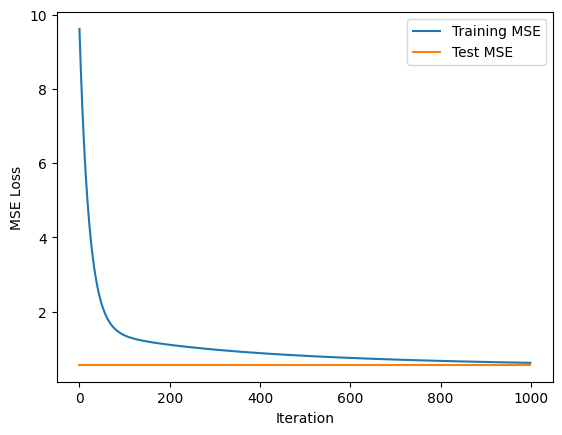

Number of iterations required to converge: 1000
Test MSE after convergence: 0.5652


In [73]:
class RidgeRegressionGradDescent(BaseLearningAlgorithm):
    def __init__(self, learning_rate=0.01, max_iterations=1000, l2_penalty=1, tolerance=1e-4):
        super().__init__()
        self.learning_rate = learning_rate
        self.max_iterations = max_iterations
        self.l2_penalty = l2_penalty
        self.tolerance = tolerance  # Define a tolerance for convergence

    def train(self, X, y):
        # Add a column of ones to X for the bias term
        X = np.hstack((np.ones((X.shape[0], 1)), X))

        # Initialize weights
        self.weights = np.random.randn(X.shape[1])

        # Initialize MSE loss history
        self.mse_loss_history = []

        # Perform gradient descent
        for i in range(self.max_iterations):
            gradient = self._compute_gradient(X, y)
            self.weights -= self.learning_rate * gradient

            # Calculate and store the MSE loss
            mse_loss = np.mean((y - self.predict(X[:, 1:])) ** 2)
            self.mse_loss_history.append(mse_loss)

            # Check for convergence based on gradient magnitude
            if np.linalg.norm(gradient) < self.tolerance:
                print(f"Converged at iteration {i + 1}")
                break

    def predict(self, X):
        X = np.hstack((np.ones((X.shape[0], 1)), X))
        return np.dot(X, self.weights)

    def _compute_gradient(self, X, y):
        y_pred = self.predict(X[:, 1:])
        error = y_pred - y
        gradient = (1 / len(X)) * (np.dot(X.T, error) + self.l2_penalty * self.weights)
        gradient = np.clip(gradient, -1e8, 1e8)
        return gradient

    @property
    def name(self):
        return "Ridge Regression Gradient Descent"

# Create an instance of the RidgeRegressionGradDescent model
ridge_regression = RidgeRegressionGradDescent(learning_rate=0.01, max_iterations=1000, l2_penalty=1, tolerance=1e-4)

# Train the model and print the iteration at which it converged
ridge_regression.train(X_train_scaled, y_train)


# Print the iteration at which it converged
print(f"Converged at iteration {i + 1}")
# Calculate the test MSE loss at each iteration
test_mse_history = [np.mean((y_test - ridge_regression.predict(X_test_scaled)) ** 2) for _ in range(ridge_regression.max_iterations)]

# Plot the MSE loss results
plt.plot(range(ridge_regression.max_iterations), ridge_regression.mse_loss_history, label='Training MSE')
plt.plot(range(ridge_regression.max_iterations), test_mse_history, label='Test MSE')
plt.xlabel('Iteration')
plt.ylabel('MSE Loss')
plt.legend()
plt.show()

# Get the number of iterations at which the training converged
converged_iterations = len(ridge_regression.mse_loss_history)

# Print the number of iterations required for convergence
print(f"Number of iterations required to converge: {converged_iterations}")

# Calculate the test MSE loss after convergence
test_predictions = ridge_regression.predict(X_test_scaled)
test_mse = np.mean((y_test - test_predictions) ** 2)
print(f"Test MSE after convergence: {test_mse:.4f}")


#5. [OPTIONAL] Iterative Optimization using Coordinate Descent

**Worth up to 2% of the semester grade.**

Review Hastie 3.8.6 and this [presentation](https://www.cs.cmu.edu/~pradeepr/convexopt/Lecture_Slides/coordinate_descent.pdf) on coordinate descent. Using just numpy reimplement part 3 with coordinate descent. Like part 3, iterate through the regression penalty term, $\lambda$, and plot (a) MSE loss as a function of $\lambda$, and (b) each coefficient weight as a function of $\lambda$. Use only numpy and matplotlib for your solution.



**Questions:**

**5.1** How does your implementation compare with Scikit-Learn’s implementation in terms of minimum MSE loss and coefficients?

**5.2** Is the optimization surface convex or non-convex?

**5.3** What makes the optimization surface *non-smooth* and how is coordinate descent able to overcome this problem?
